# 正则化

这是本小节的第二个实战编程。 前面的文章已经说了，如果神经网络过拟合了，就会出现神经网络对训练数据集的预测效果很好，但是到实际使用时，效果就很差。为了解决过拟合问题，添加数据量是肯定有效的，但是数据太难获取也太贵，所以首选方案就是正则化了。所以说，正则化是很重要的。本次实战编程就带领大家对正则化进行进一步地直观认识！

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**假设我们要解决这样一个问题**: 法国足球公司聘请你为AI专家，用AI手段分析出守门员应该将球踢到哪个位置是最合适的，在这个位置上本队的队员能最大概率地接住自己守门员踢出的球。

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **图1** </u>: **足球场（蓝点是法国足球员）**<br> </center></caption>

公司里给了你过去10场比赛的数据集，如下图所示。

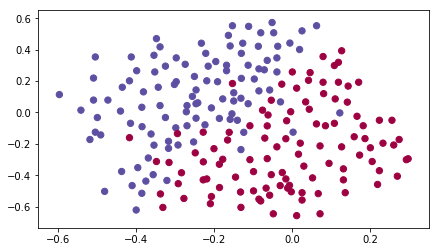

In [12]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

上图的每一个点就是之前比赛中在法国守门员踢出球后被接住的位置
- 如果点是蓝色的，那么表示接住球的是法国队员。
- 如果是红色的点，表示接住球的是对方球队的球员。

**我们的目标是**: 使用神经网络模型来找出守门员应该踢到哪些位置比较好，比较容易让本队队员接住球.

首先，我们会尝试使用不加正则化的模型。然后，再加入正则化。这样可以形成鲜明对比。没有对比就没有伤害~~ 有了对比，你就更加能体会到正则化是多么的重要了！

## 1 - 不加正则化的模型

下面就是我们将使用的神经网络模型函数。这个函数会根据输入的参数不同而选择是否为模型添加正则化。
- 如果要添加 *L2正则化* -- 那么就将参数lambd设置为非0的值。
- 如果要使用 *dropout* --  那么就设置keep_prob为小于1的数。

这个函数里面的大部分工具函数已经在reg_utils.py里面实现好了，通过前面的实战编程，我们已经很熟悉它们了，无需再浪费篇幅展示它们。

里面的compute_cost_with_regularization()和backward_propagation_with_regularization()这个两个函数是用于实现L2正则化的；forward_propagation_with_dropout()和backward_propagation_with_dropout()是用于实现dropout的。这4个函数的实现是我们本次实战编程的重点。

In [13]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):       
    grads = {}
    costs = []                            
    m = X.shape[1]                        
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # 防止同时使用L2正则化和dropout。
        # 其实是可以同时使用它们的，但是为了教学目的，突出重点，所以单次只允许用其中一个。
        assert(lambd == 0 or keep_prob == 1)    
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

首先，我们对不加正则化的模型进行训练。然后观察训练好的模型对训练数据集和测试数据集的预测精准度。

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.163299875257242
Cost after iteration 20000: 0.13851642423257143


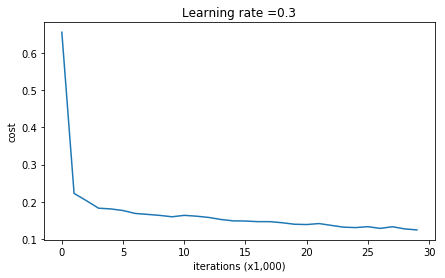

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [14]:
parameters = model(train_X, train_Y)
print("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

上面的模型对训练数据集的预测精准度是94.8%，而对测试数据集的精准度是91.5%。看起来还不错。但是添加了正则化之后，效果会更好。

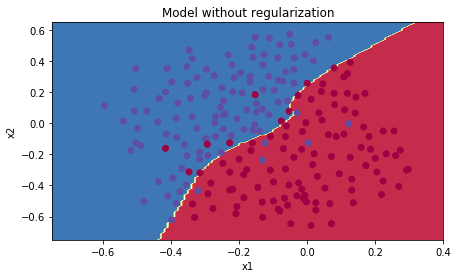

In [31]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

从上图可以看出，未添加正则化的模型对训练数据产生了过拟合。它把红色区域里面的那几个蓝点和蓝色区域的几个红点也拟合了。这几个点是错误的数据，或者说着极端的特例，就像马云这样的成功案例，它们不是常规现象，应该被忽略掉。

## 2 - L2正则化

L2正则化是解决过拟合的常用方法之一. 

L2主要有两部分组成，第一步是在成本函数后面加个尾巴,下面是常规的成本函数:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
下面是加了L2尾巴的成本函数:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2尾巴} \tag{2}$$

下面的函数实现了上面的公式

In [16]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    # 获得常规的成本
    cross_entropy_cost = compute_cost(A3, Y) 
    
    #计算L2尾巴
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [17]:
# 单元测试
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


第二步，在反向传播计算偏导数时在dW后加上L2尾巴 $\frac{\lambda}{m} W$.

In [18]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1. / m * np.dot(dZ3, A2.T) + (lambd * W3) / m
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T) + (lambd * W2) / m
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T) + (lambd * W1) / m
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [19]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd=0.7)
print ("dW1 = " + str(grads["dW1"]))
print ("dW2 = " + str(grads["dW2"]))
print ("dW3 = " + str(grads["dW3"]))

dW1 = [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691347 -0.11832879 -0.09397446]]


下面我们通过设置模型函数`model()`的参数$\lambda$来构建添加了L2正则化的神经网络模型。 $(\lambda = 0.7)$。 `model()` 函数里面会上面我们实现的L2函数: 
- 用`compute_cost_with_regularization` 取代了 `compute_cost`
- 用`backward_propagation_with_regularization` 取代了 `backward_propagation`

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


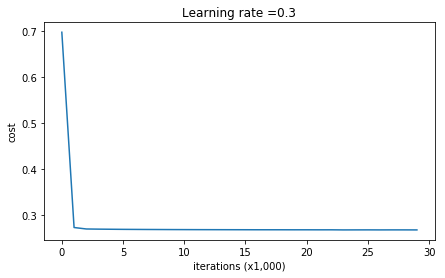

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [20]:
parameters = model(train_X, train_Y, lambd=0.7)
print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

恭喜，模型对测试数据集的预测精准度和对训练数据集的一样了。这说明模型变得可靠了。不会出现在公司里研发时模型表现得杠杠的，一出公司进行商用就表现得不尽人意。

从下图中可以看出，模型对训练数据集不再拟合过度了。模型忽略了那些错误的点那些极端特例。

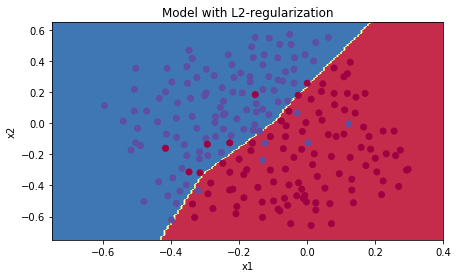

In [23]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

**注意**:
- 参数$\lambda$是可以调试的超参数.
- 对比不添加正则化的模型，我们可以发现，L2使预测的线条更加平滑了。如果将参数$\lambda$设置得太大，那么线条就会平滑过度，就会出现对训练数据集欠拟合。建议你自己调试一下$\lambda$玩玩看。

建议大家一边再次阅读前面的相关文章一边看本小节的代码。温故而知新。孔夫子的话是很有道理的！

## 3 - Dropout

**dropout**也是一个被深度学习领域经常用到的解决过拟合的方法。 

下面这段对话可以有助于理解dropout:
- 你的朋友: "为什么你需要所有的神经元来参与神经网络模型的训练?". 
- 你: "因为每一个神经元都能学到一个特定的知识，例如一类线条一种颜色一些形状。。。我有越多的神经元，那么我的神经网络就能学到越多的知识!"
- 你的朋友: "我明白，但是你确定你的所有神经元都学到了不同的知识吗，而不是所有的碰巧都只学会了认识红色而没有一个神经元学会了识别蓝色？"
- 你: "我了个去，你的这个问题问得太好了。。。同一层的神经元相互之间没有联系，无法互相交流，所以极有可能它们都学会了同一种知识点。。。如果每次都随机地删除一些神经元，那么网络结构发生了变化，那么它们学到相同知识点的概率就很低了"

**dropout在训练的每个回合中都随机地删除一些神经元**，下面的视频直观地展示了dropout的过程!

<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> 图 2 </u>: 在第二层执行dropout. <br> 上面的视频里，训练的每个回合中，第二层都会有一些神经元被删除掉，这里是删除50%的神经元。删除的神经元在这个回合的前向传播和反向传播中都不会起任何作用 </center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> 图 3 </u>: 在第一层和第三层执行dropout <br> 第一层中，我们删除了40%的神经元；第三层中删除了20%的神经元 </center></caption>

使用dropout后，每个回合我们训练的神经网络模型都被改变了，每个回合都只训练了一部分神经元。这样一来，神经元就不会太依赖于上一层的某个神经元了，因为上一层的那个神经元可能下个回合就被删除掉了。

### 3.1 - dropout的前向传播

下面的函数实现了加入了dropout的前向传播。这个神经网络总共3层，函数中对第一层和第二层进行了dropout。通常我们不会在输入层和输出层进行dropout。

** 主要通过下面4步来实现dropout **
1. 在前面的文章中，我们提到了使用 `np.random.rand()`来创建一个与 $a^{[1]}$维度相同的 $d^{[1]}$。`np.random.rand()`会生成0到1之间的随机数。下面的函数中，我们实现了一个向量化的版本，创建了与 $A^{[1]}$维度相同的矩阵 $D^{[1]}$,$D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $.

2. 函数中会通过设置阈值的方式来将$D^{[1]}$中(`1-keep_prob`)百分比个元素设置为0，将占比`keep_prob`个元素设置为1。 例如，如果你想将矩阵X的所有元素都设置为0（当元素原来的值 < 0.5时）或1（如果元素原来的值>0.5），那么可以用这个公式 `X = (X < 0.5)`. 这个0.5就是一个阈值，我们这里将`keep_prob`作为阈值。另外，在python中，False和True相当于0和1.

3. 然后让 $A^{[1]}$ 等于 $A^{[1]} * D^{[1]}$. 这样$A^{[1]}$某些元素与$D^{[1]}$中的0元素相乘之后，$A^{[1]}$中的相应元素也变成0了。相应的a被设置为0后，它对应的神经元就等于被删除掉了。

4. 最后一步，将 $A^{[1]}$ 除以 `keep_prob`. 通过这一步使运用了dropout的神经网络的期望值和没有用dropout的神经网络的期望值保持一样。这种dropout我们称为inverted dropout。详情温故我前面的文章。

In [24]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
   
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
   
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # 第一步
    D1 = D1 < keep_prob                            # 第二步
    A1 = A1 * D1                                      # 第三步
    A1 = A1 / keep_prob                               # 第四步

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    D2 = np.random.rand(A2.shape[0], A2.shape[1])     
    D2 = D2 < keep_prob                                             
    A2 = A2 * D2                                  
    A2 = A2 / keep_prob               

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [25]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob=0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


### 3.2 - 带dropout的反向传播

**主要有两个步骤**:
1. 在前向传播时，我们通过使用掩码$D^{[1]}$与`A1`进行运算而删除了一些神经元。在反向传播时，我们也必须删除相同的神经元，这个可以通过使用相同的$D^{[1]}$与`dA1`进行运算来实现。
2. 在前向传播时，我们将`A1`除以了`keep_prob`。在反向传播时，我们也必须将`dA1`除以`keep_prob`。微积分层面的解释是：如果$A^{[1]}$被`keep_prob`进行了缩放，那么它的导数$dA^{[1]}$也应该被相应地缩放。

In [26]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2 * D2              # 第一步
    dA2 = dA2 / keep_prob              # 第二步

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1 * D1              
    dA1 = dA1 / keep_prob             

    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [27]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob=0.8)

print ("dA1 = " + str(gradients["dA1"]))
print ("dA2 = " + str(gradients["dA2"]))

dA1 = [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


下面我们对带dropout的神经网络模型进行训练。设置`keep_prob = 0.86`，这意味着训练的每个回合中在第一层和第二层中都会有24%的神经元被删除掉。`model()`函数里面会使用新的前向传播和反向传播函数：
- 用`forward_propagation_with_dropout`取代了 `forward_propagation`.
- 用`backward_propagation_with_dropout`取代了 `backward_propagation`.

Cost after iteration 0: 0.6543912405149825


C:\Users\Capta\AI blog\My\5 正则化\reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\Capta\AI blog\My\5 正则化\reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.0610169865749056
Cost after iteration 20000: 0.060582435798513114


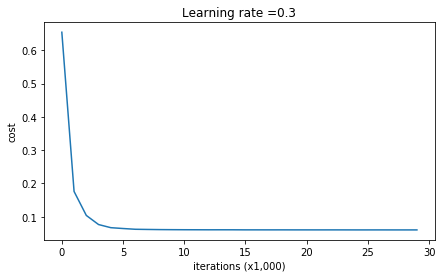

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [28]:
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3)

print("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

从上面的结果可以看出，dropout表现得非常棒。模型对测试集的预测准确率达到了95%。

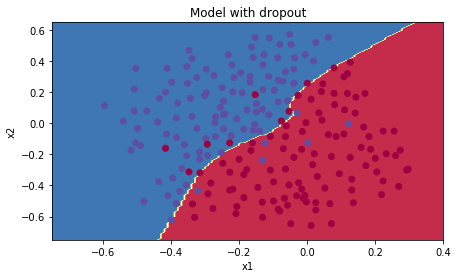

In [30]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

**提示**:
- 如我前面的文章提到的，千万不要在实际使用时也运行dropout，应该只在训练模型时使用dropout。 
- 大部分深度学习框架，例如[tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) 以及 [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) 都自带dropout的实现。在后面的课程中，我马上就会带领大家来学习和使用这些框架。

<font color='blue'>
**关于dropout你应该记住以下几个要点:**
- Dropout是一种正则化技术.
- 只能在训练模型时运行dropout，在使用模型时要把dropout关掉。
- 在前向传播和反向传播中都要实现dropout.
- 要记住在每层的前向传播和反向传播中都除以keep_prob来保证期望值不变.

## 4 - 总结

**下面是我们3种模型的结果**: 

<table> 
    <tr>
        <td>
        **模型**
        </td>
        <td>
        **训练集准确度**
        </td>
        <td>
        **测试集准确度**
        </td>

    </tr>
        <td>
        无正则化的模型
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        L2正则化模型
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        dropout模型
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

其实正则化会影响训练数据集的性能，因为它为了防止对训练数据集过拟合而限制了神经网络的性能。但是最终正则化使我们的模型对测试集的预测准确率提升了，所以它是对神经网络有益的。解决过拟合最完美的方法是增加训练数据，但是我们无法得到更多的数据~~

恭喜你！学完了本次实战编程！ 请务必自己动手一步一步地敲代码实现本次实战编程！

<font color='blue'>
**最后，再加深下面几个知识点的印象**:
- 正则化能解决过拟合问题.
- 正则化会使权重变小.
- L2正则化和dropout是两个效率非常高的正则化技术